# 3 sites Bose Hubbard model via Skolem Tridiagonalization 

## Number theoretical tools: The Skolem polynomials and its inverse

In [1]:
from scipy.special import comb


def combinadics_from_index(N, k):
    """
    This function converts a natural number N as sequences of k-combinations. 
    This is referred to as the combinatorial number system of degree k (for some positive integer k).
    
    See https://planetcalc.com/8592/
    """
    combinadics = [0] * k
    
    c_start = max(N, k)
    
    for j in range(k, 0, -1):
        #############################################################
        # Find the value of c using the bisection method.
        # This part was generated by ChatGPT
        #############################################################
        left = 0
        right = c_start + 1  # Increase the range by 1 to include c_start
        while left < right:
            mid = (left + right) // 2
            q = comb(mid, j)
            if q <= N:
                left = mid + 1
            else:
                right = mid
        c = left - 1  # Return the previous value since q > N
        #############################################################
        
        q = comb(c, j)
        c_start = c - 1
        N -= q
        combinadics[k - j] = c
    
    return combinadics

def index_from_combinadics(combinadics):
    """
    This function returns index from the combinadics.
    
    Note:
        assert index_from_combinadics(combinadics_from_index(N, k)) == N
    """
    return sum(
        comb(c, j + 1) for j, c in enumerate(reversed(combinadics))
    )

def skolem(ntuple):
    """
    Evaluate the Skolem polynomial from tuple
    """
    return int(sum(
        comb(sum(ntuple[:k]) + k - 1, k) for k in range(1, len(ntuple) + 1)
    ))

def tuple_from_skolem(S, k):
    "The inverse of the Skolem polynomials"
    
    combinadics = combinadics_from_index(S, k)
    
    assert index_from_combinadics(combinadics) == S

    ntuple = [0] * k
    
    ntuple[0] = combinadics[-1]
    
    for j in range(1, k):
        ntuple[j] = combinadics[k - j - 1] - j - sum(ntuple[:j])
    
    return ntuple

In [2]:
# trivial test

tuple_from_skolem(skolem([0, 100, 1]), 3)

[0, 100, 1]

In [3]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import eigh_tridiagonal, expm

U = 1
J = 1
Δt = 0.1

N = 100

# the cut off of Skolem index
S_max = max(skolem([N, 0, 0]), skolem([0, N, 0]), skolem([0, 0, N]))

skolem_321 = np.arange(skolem([0, 0, N]), skolem([N, 0, 0]) + 1)

# This ordering is to be compartible with QuSpin
n3, n2, n1 = np.array(
    [tuple_from_skolem(S, 3) for S in skolem_321]
).T

## Reindex (n3, n2, n1) <-> (n1, n2, n3)
indx = np.array([
    skolem(_) for _ in zip(n1, n2, n3)
]) - skolem([0, 0, N])

## QuSpin

Comparing the implementation of the Bose-Hubbard Model in the QuSpin library by following: https://github.com/weinbe58/QuSpin/blob/master/examples/notebooks/BHM.ipynb

In [4]:
from quspin.operators import hamiltonian # Hamiltonians and operators
from quspin.basis import boson_basis_1d # Hilbert space boson basis


##### construct Bose-Hubbard Hamiltonian #####
# define boson basis with N states per site L bosons in the lattice
L = 3
basis = boson_basis_1d(3, Nb=N) # full boson basis
print(basis)
print("\n")

print(n1, n2, n3)

reference states: 
array index   /   Fock state   /   integer repr. 
        0.         |100   0   0>           1020100  
        1.         | 99   1   0>           1010000  
        2.         | 99   0   1>           1009900  
        3.         | 98   2   0>            999900  
        4.         | 98   1   1>            999800  
        5.         | 98   0   2>            999700  
        6.         | 97   3   0>            989800  
        7.         | 97   2   1>            989700  
        8.         | 97   1   2>            989600  
        9.         | 97   0   3>            989500  
       10.         | 96   4   0>            979700  
       11.         | 96   3   1>            979600  
       12.         | 96   2   2>            979500  
       13.         | 96   1   3>            979400  
       14.         | 96   0   4>            979300  
       15.         | 95   5   0>            969600  
       16.         | 95   4   1>            969500  
       17.         | 95   3   

### $\hat{H}_{23}$ via QuSpin

Hermiticity check passed!
Particle conservation check passed!


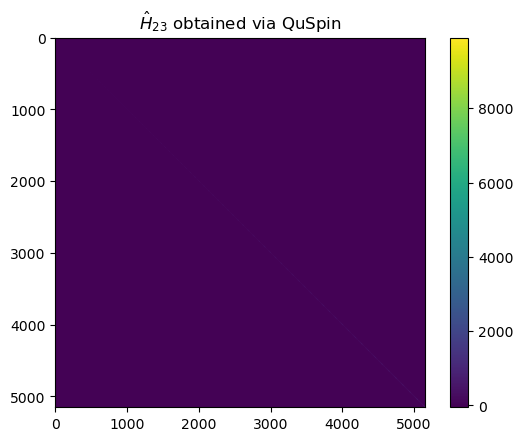

In [5]:
H_23 = hamiltonian(
    [
        ['+-', [[-J, 1, 2]]], 
        ['-+', [[-J, 1, 2]]], 
        ['nn', [[0.5 * U, 1, 1], [U, 2, 2]]], 
        ['n', [[-0.5 * U, 1], [-U, 2]]]
    ], 
    [], 
    basis = basis, 
    dtype = np.float64,
    check_symm = False
)

plt.title("$\hat{H}_{23}$ obtained via QuSpin")
plt.imshow(H_23.todense())
plt.colorbar()
plt.show()

### Get $\exp(-i\Delta t \hat{H}_{23})$ via tridiagonalization

In [6]:
E_23_tridiag, v = eigh_tridiagonal(
    0.5 * U * n2 * (n2 - 1) + U * n3 * (n3 - 1),
    -J * np.sqrt((n2 + 1) * n3)[1:],
)

expH_23_tridiag = (v * np.exp(-1j * Δt * E_23_tridiag)) @ v.T

compare

In [7]:
np.allclose(
    expH_23_tridiag, 
    expm(-1j * Δt * H_23.todense())
)

True

### $\hat{H}_{12}$ via QuSpin

In [8]:
H_12 = hamiltonian(
    [
        ['+-', [[-J, 0, 1]]], 
        ['-+', [[-J, 0, 1]]], 
        ['nn', [[U, 0, 0], [0.5 * U, 1, 1]]], 
        ['n', [[-U, 0], [-0.5 * U, 1]]]
    ],
    [], 
    basis = basis, 
    dtype = np.float64,
    check_symm = False
)

Hermiticity check passed!
Particle conservation check passed!


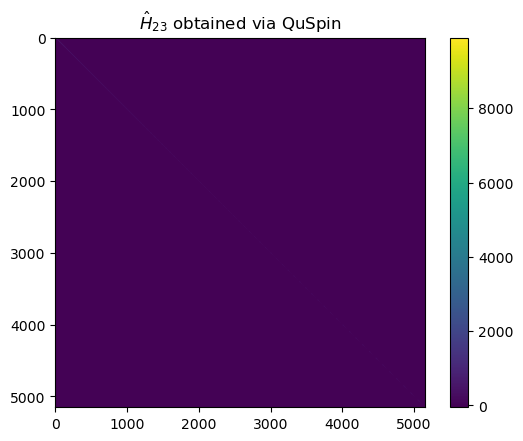

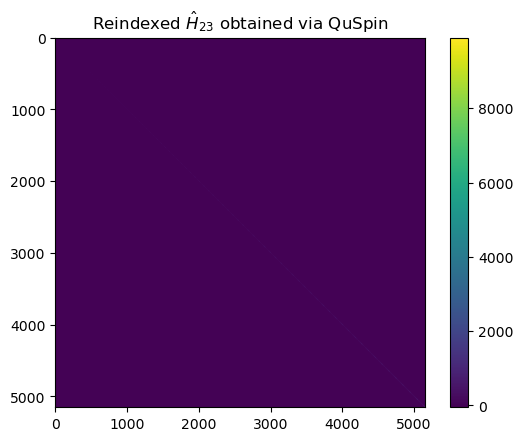

In [9]:
plt.title("$\hat{H}_{23}$ obtained via QuSpin")
plt.imshow(H_12.todense())
plt.colorbar()
plt.show()

plt.title("Reindexed $\hat{H}_{23}$ obtained via QuSpin")
plt.imshow(H_12.todense()[indx, :][:, indx])
plt.colorbar()
plt.show()


Comparing 

In [10]:
np.allclose(
    expH_23_tridiag[indx, :][:, indx], 
    expm(-1j * Δt * H_12.todense())
)

True

Hence, we get the desired split operator propagation matrix  

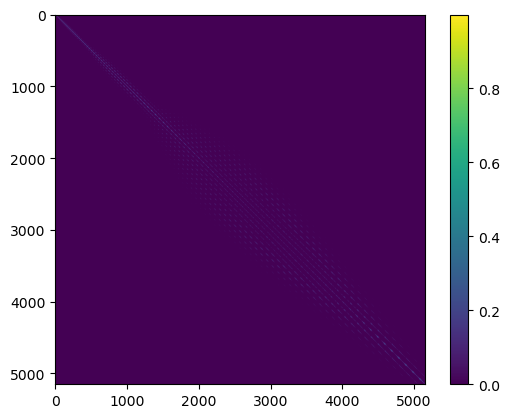

In [11]:
plt.imshow(
    np.abs(
        expH_23_tridiag @ expH_23_tridiag[indx, :][:, indx]
    )
)

plt.colorbar()